In [23]:
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.utils import to_categorical

pixels = np.load('digits_pixels.npy')
n_cols = pixels.shape[1]
input_shape = (n_cols,)
numbers = to_categorical(np.load('digits_target.npy'))

from sklearn.model_selection import train_test_split

pixels_train, pixels_test, numbers_train, numbers_test = \
  train_test_split(pixels, numbers, test_size=0.3)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
  Dense(16, activation='relu', input_shape=input_shape),
  Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-11-17 11:22:51.212970: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-17 11:22:51.213059: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-17 11:22:51.213094: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-FC4EGDV): /proc/driver/nvidia/version does not exist
2021-11-17 11:22:51.213500: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Check to see if the untrained model works as expected
model.predict(pixels_train)

2021-11-17 11:22:51.385152: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


array([[1.9380886e-05, 1.1095664e-06, 8.6964585e-04, ..., 9.8799324e-01,
        4.7014223e-04, 1.2923523e-07],
       [1.4940484e-06, 5.6697603e-04, 9.4086504e-01, ..., 4.8837021e-02,
        9.6244877e-03, 2.9304151e-06],
       [6.1206200e-09, 7.2778476e-04, 2.6200499e-04, ..., 9.9812645e-01,
        4.3960758e-06, 6.6552245e-12],
       ...,
       [1.8190215e-12, 2.3862810e-03, 6.3687094e-07, ..., 9.9759585e-01,
        5.2217041e-07, 6.9322464e-15],
       [3.2014441e-04, 8.3502069e-05, 4.0038818e-04, ..., 9.7678024e-01,
        9.7838645e-05, 2.1698037e-07],
       [4.7526418e-09, 7.6527834e-07, 3.2113942e-07, ..., 9.9978334e-01,
        4.6287691e-06, 2.4943556e-12]], dtype=float32)

In [5]:
# Plot the training history
history = model.fit(pixels_train, numbers_train, epochs=60, validation_data=(pixels_test, numbers_test), verbose=False)

plt.plot(history.history['loss'], color='black', label='Training loss')
plt.plot(history.history['val_loss'], color='red', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('categorical_crossentropy')
plt.yscale('log')
plt.legend()
plt.show()

In [15]:
# What is the effect of adding more training data?
# Create an untrained model to use for experimentation

# Untrained model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
  Dense(16, activation='relu', input_shape=input_shape),
  Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save initial weights to allow for experimentation
initial_weights = model.get_weights()

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=1)

# Experiment metrics
train_accuracies = []
test_accuracies = []

# Define the number of training sizes
# to use in each round of experimentation
training_sizes = np.array([ 125,  502,  879, 1255])
for training_size in training_sizes:
  # Get a fraction of the training data
  pixels_train_frac = pixels_train[:training_size]
  numbers_train_frac = numbers_train[:training_size]
  
  # Reset the model to the initial weights
  # And train it on the new data fraction
  model.set_weights(initial_weights)
  model.fit(pixels_train_frac, numbers_train_frac, epochs=50, callbacks=[early_stop], verbose=False)

  # Record results
  train_accuracy = model.evaluate(pixels_train_frac, numbers_train_frac)[1]
  test_accuracy = model.evaluate(pixels_test, numbers_test)[1]
  
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)

17/17 [==============================] - 0s 4ms/step - loss: 0.1636 - accuracy: 0.9556


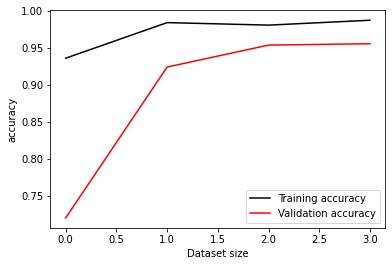

In [25]:
plt.plot(train_accuracies, color='black', label='Training accuracy')
plt.plot(test_accuracies, color='red', label='Validation accuracy')
plt.xlabel('Dataset size')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [3]:
# We go back to the irrigation model

# Parcel irrigation data
# Three parcels, ¿do we have to irrigate or not?
irrigation = pd.read_csv('irrigation_machine.csv').drop('Unnamed: 0', axis=1)
parcel_columns = ['parcel_0', 'parcel_1', 'parcel_2']
parcels = irrigation[parcel_columns].values
sensors = irrigation.drop(parcel_columns, axis=1).values

from sklearn.model_selection import train_test_split
sensors_train, sensors_test, parcels_train, parcels_test = \
  train_test_split(sensors, parcels, test_size=0.3)

In [5]:
# We produce new models using a function
# This allow us to quickly experiment with different activation functions

def get_model(activation_function):
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense, Dropout

  nodes = 2**7
  rate = 0.8

  model = Sequential([
    Dense(nodes, activation=activation_function, input_shape=(20,)),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(nodes, activation=activation_function),
    Dropout(rate=rate),
    Dense(3, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

# Example
model = get_model('relu')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               2688      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [34]:
# Activation functions to try
activations = ['relu', 'leaky_relu', 'sigmoid', 'tanh']

# Store experimentation results
activation_results = {}

for activation in activations:
  model = get_model(activation)
  history = model.fit(sensors_train, parcels_train, epochs=2**10, validation_data=(sensors_test, parcels_test), verbose=False)
  activation_results[activation] = history

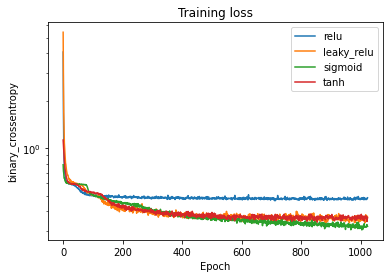

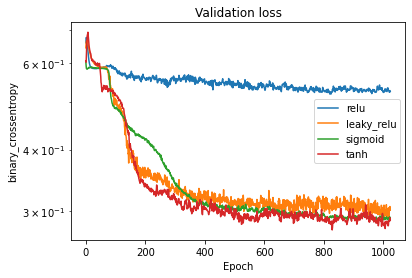

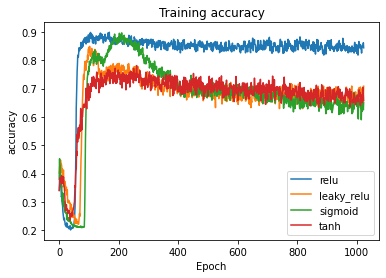

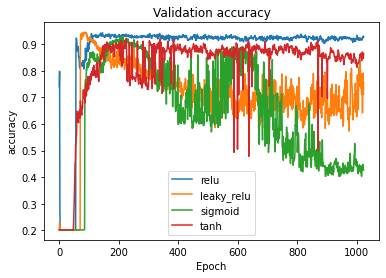

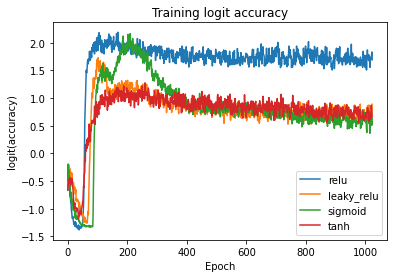

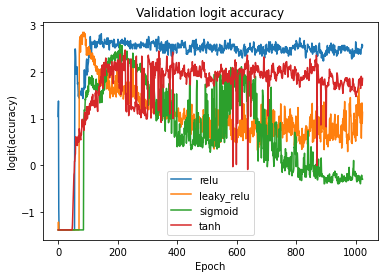

In [35]:
def metric_df(metric):
  return pd.DataFrame({activation: activation_results[activation].history[metric] for activation in activations})

loss = metric_df('loss')
val_loss = metric_df('val_loss')
accuracy = metric_df('accuracy')
val_accuracy = metric_df('val_accuracy')


loss.plot()
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("binary_crossentropy")
plt.yscale("log")
plt.show()

val_loss.plot()
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("binary_crossentropy")
plt.yscale("log")
plt.show()

accuracy.plot()
plt.title("Training accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

val_accuracy.plot()
plt.title("Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.show()

sp.special.logit(accuracy).plot()
plt.title("Training logit accuracy")
plt.xlabel("Epoch")
plt.ylabel("logit(accuracy)")
plt.show()

sp.special.logit(val_accuracy).plot()
plt.title("Validation logit accuracy")
plt.xlabel("Epoch")
plt.ylabel("logit(accuracy)")
plt.show()